# Experiments analysis

## Dependencies

In [1]:
import msgpack
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200

## Variables

In [2]:
base_dir = "logs"

last_step = 3600

nodes = [100, 196]

users_per_apps = [4, 16]

logs = [
    ("central", "central;nodes={nodes};users_per_app={users_per_app}"),
    ("community", "community12p;nodes={nodes};users_per_app={users_per_app}"),
    ("community", "community25p;nodes={nodes};users_per_app={users_per_app}"),
    ("p2p", "p2p;nodes={nodes};users_per_app={users_per_app}"),
    ("dynamic", "p2p;nodes={nodes};users_per_app={users_per_app}"),
    ("resource_aware_dynamic", "p2p;nodes={nodes};users_per_app={users_per_app}", "1"),
    ("resource_aware_dynamic", "p2p;nodes={nodes};users_per_app={users_per_app}", "2"),
    ("resource_aware_dynamic", "p2p;nodes={nodes};users_per_app={users_per_app}", "3"),
    ("resource_aware_dynamic", "p2p;nodes={nodes};users_per_app={users_per_app}", "4"),
]

seed = "1"

algorithm_map = {
    "central": "Central",
    "community": "Comm.",
    "p2p": "P2P",
    "dynamic": "LM Dyn.",
    "resource_aware_dynamic": "RR Dyn.",
}

algorithm_labels = ["Central", "Comm. (12%)", "Comm. (25%)", "P2P", "LM Dyn.", "RR Dyn. (1)", "RR Dyn. (2)", "RR Dyn. (3)", "RR Dyn. (4)"]

## Base functions

### Edge Server Disk

In [3]:
"""
log = logs[1]

es_msgpack_file = (
    f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"
    if len (log) == 2
    else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/EdgeServer.msgpack"
)
es_file = open(es_msgpack_file, "rb")
es_msgpack = msgpack.load(es_file, strict_map_key=False)
es_df = pd.DataFrame(es_msgpack)
"""

'\nlog = logs[1]\n\nes_msgpack_file = (\n    f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"\n    if len (log) == 2\n    else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/EdgeServer.msgpack"\n)\nes_file = open(es_msgpack_file, "rb")\nes_msgpack = msgpack.load(es_file, strict_map_key=False)\nes_df = pd.DataFrame(es_msgpack)\n'

### Latency

In [4]:
def get_latency_data(nodes, users_per_app, user_type=None):
    user_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(nodes=nodes, users_per_app=users_per_app)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Mean": 0,
            "Sum": 0,
        }

        # Opening file
        user_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/User.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/User.msgpack"
        )
        user_file = open(user_msgpack_file, "rb")
        user_msgpack = msgpack.load(user_file)
        user_df = pd.DataFrame(user_msgpack)

        # Collecting information
        latency = (
            user_df[["Object", "Delays"]]
            if user_type is None
            else user_df[user_df["User Type"] == user_type][["Object", "Delays"]]
        )

        # Persisting information
        simulation_data["Delays"] = latency["Delays"]
        simulation_data["Mean"] = latency["Delays"].mean()
        simulation_data["Sum"] = latency["Delays"].sum()

        # Closing file
        user_file.close()

        # Appending data
        user_data.append(simulation_data)

    return pd.DataFrame(user_data)

### Provisioning Time

In [5]:
def get_provisioning_time_data(step, nodes, users_per_app):
    service_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(nodes=nodes, users_per_app=users_per_app)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Prov. Time Values": [],
            "Mean": 0,
            "Sum": 0,
        }

        # Opening file
        service_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Service.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/Service.msgpack"
        )
        service_file = open(service_msgpack_file, "rb")
        service_msgpack = msgpack.load(service_file)
        service_df = pd.DataFrame(service_msgpack)

        # Collecting information
        migrations_duration = service_df[service_df["Time Step"] == step]["Migrations Duration"].apply(pd.Series).stack().reset_index(drop=True)

        # Persisting information
        simulation_data["Prov. Time Values"] = service_df[service_df["Time Step"] == step]["Migrations Duration"].apply(pd.Series).stack().reset_index(drop=True)
        simulation_data["Mean"] = migrations_duration.mean()
        simulation_data["Sum"] = migrations_duration.sum()

        # Closing file
        service_file.close()

        # Appending data
        service_data.append(simulation_data)

    return pd.DataFrame(service_data)

### Service Reallocations

In [6]:
def get_reallocations_data(step, nodes, users_per_app):
    service_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(nodes=nodes, users_per_app=users_per_app)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Only Using Cache": 0,
            "Partially Using Cache": 0,
            "Not Using Cache": 0,
            "Total Migrations": 0,
            "Only Using Cache (%)": 0,
            "Partially Using Cache (%)": 0,
            "Not Using Cache (%)": 0,
        }

        # Opening file
        service_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Service.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/Service.msgpack"
        )
        service_file = open(service_msgpack_file, "rb")
        service_msgpack = msgpack.load(service_file)
        service_df = pd.DataFrame(service_msgpack)

        # Collecting information
        migrations_last_step = service_df[service_df["Time Step"] == step][["Object", "Migrations (Only Cache)", "Migrations (Partial Cache)", "Migrations (No Cache)"]]

        # Persisting information
        simulation_data["Only Using Cache"] = service_df[service_df["Time Step"] == step]["Migrations (Only Cache)"].sum()
        simulation_data["Partially Using Cache"] = service_df[service_df["Time Step"] == step]["Migrations (Partial Cache)"].sum()
        simulation_data["Not Using Cache"] = service_df[service_df["Time Step"] == step]["Migrations (No Cache)"].sum()
        simulation_data["Total Migrations"] = simulation_data["Only Using Cache"] + simulation_data["Partially Using Cache"] + simulation_data["Not Using Cache"]
        simulation_data["Only Using Cache (%)"] = simulation_data["Only Using Cache"] / simulation_data["Total Migrations"]
        simulation_data["Partially Using Cache (%)"] = simulation_data["Partially Using Cache"] / simulation_data["Total Migrations"]
        simulation_data["Not Using Cache (%)"] = simulation_data["Not Using Cache"] / simulation_data["Total Migrations"]

        # Closing file
        service_file.close()

        # Appending data
        service_data.append(simulation_data)

    return pd.DataFrame(service_data)

### Registry Usage

In [7]:
def get_registry_usage_data(nodes, users_per_app):
    registry_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(nodes=nodes, users_per_app=users_per_app)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Values": [],
            "Values (w/o 0%)": [],
            "Mean": 0,
            "Total": 0,
        }

        # Opening file
        registry_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/ContainerRegistry.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/ContainerRegistry.msgpack"
        )
        registry_file = open(registry_msgpack_file, "rb")
        registry_msgpack = msgpack.load(registry_file)
        registry_df = pd.DataFrame(registry_msgpack)

        # Collecting information
        registry_filtered_data = (
            registry_df[registry_df["P2P"] == True][["Object", "Provisioning", "Not Provisioning"]]
            if log[1] == "p2p"
            else registry_df[["Object", "Provisioning", "Not Provisioning"]]
        )
        registry_data_grouped = registry_filtered_data.groupby("Object").sum()
        registry_data_grouped["Total Steps"] = registry_data_grouped.sum(axis=1)
        registry_data_grouped["Provisioning Percentage"] = registry_data_grouped["Provisioning"] / registry_data_grouped["Total Steps"]
        registry_data_grouped["Not Provisioning Percentage"] = registry_data_grouped["Not Provisioning"] / registry_data_grouped["Total Steps"]

        # Persisting information
        simulation_data["Values"] = registry_data_grouped["Provisioning Percentage"]
        simulation_data["Values (w/o 0%)"] = registry_data_grouped[registry_data_grouped["Provisioning Percentage"] > 0]["Provisioning Percentage"]
        simulation_data["Mean"] = registry_data_grouped["Provisioning Percentage"].mean()
        simulation_data["Total"] = registry_data_grouped["Total Steps"].sum()
        

        # Closing file
        registry_file.close()

        # Appending data
        registry_data.append(simulation_data)

    return pd.DataFrame(registry_data)

### Number of Registries per Time Step

In [8]:
def get_number_of_registries_data(nodes, users_per_app):
    registry_data = {}

    for index, log in enumerate(logs):
        # Formatting log
        log = list(log)
        log[1] = log[1].format(nodes=nodes, users_per_app=users_per_app)

        # Opening file
        registry_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/ContainerRegistry.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/ContainerRegistry.msgpack"
        )
        registry_file = open(registry_msgpack_file, "rb")
        registry_msgpack = msgpack.load(registry_file)
        registry_df = pd.DataFrame(registry_msgpack)

        # Collecting information
        registries_per_timestep = registry_df[registry_df["Time Step"] > 0].groupby(["Time Step"]).count()["Object"]

        # Persisting information
        registry_data[algorithm_labels[index]] = registries_per_timestep

        # Closing file
        registry_file.close()

    registries_per_timestep_df = pd.concat(registry_data, axis=1)

    return registries_per_timestep_df

### Server Utilization per Time Step

In [9]:
def normalize_cpu_and_memory(cpu, memory) -> float:
    """Normalizes the CPU and memory values.

    Args:
        cpu (float): CPU value.
        memory (float): Memory value.

    Returns:
        normalized_value (float): Normalized value.
    """
    normalized_value = (cpu * memory) ** (1 / 2)
    return normalized_value
    
def get_server_utilization_data(nodes, users_per_app):
    server_data = {}

    for index, log in enumerate(logs):
        # Formatting log
        log = list(log)
        log[1] = log[1].format(nodes=nodes, users_per_app=users_per_app)
        
        # Opening file
        server_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/EdgeServer.msgpack"
        )
        server_file = open(server_msgpack_file, "rb")
        server_msgpack = msgpack.load(server_file)
        server_df = pd.DataFrame(server_msgpack)

        # Collecting information
        server_df = server_df[["Object", "CPU", "RAM", "CPU Demand", "RAM Demand", "Time Step"]]
        server_df["Normalized Utilization"] = server_df.apply(lambda row: normalize_cpu_and_memory(row["CPU Demand"], row["RAM Demand"])/normalize_cpu_and_memory(row["CPU"], row["RAM"]), axis=1)
        
        server_per_timestep = server_df[server_df["Time Step"] > 0].groupby(["Time Step"])["Normalized Utilization"].mean()

        # Persisting information
        server_data[algorithm_labels[index]] = server_per_timestep

        # Closing file
        server_file.close()

    return pd.concat(server_data, axis=1)

### Image Replication per Time Step

In [10]:
def get_image_replication_data(log):
    # Opening file
    topology_msgpack_file = (
        f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Topology.msgpack"
        if len (log) == 2
        else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/Topology.msgpack"
    )
    topology_file = open(topology_msgpack_file, "rb")
    topology_msgpack = msgpack.load(topology_file, strict_map_key=False)
    topology_df = pd.DataFrame(topology_msgpack)

    # Collecting information
    image_replication_data = topology_df[["Object", "Replication Data", "Time Step"]]
    image_replication_data = pd.json_normalize(image_replication_data["Replication Data"]).fillna(0)
    image_replication_data = image_replication_data.divide(image_replication_data.sum(axis=1), axis=0)

    # Sort headers
    image_replication_data = image_replication_data.reindex(sorted(image_replication_data.columns), axis=1)

    # Closing file
    topology_file.close()

    return image_replication_data

### Disk Occupation

In [11]:
   
def get_total_disk_utilization_data(nodes, users_per_app):
    server_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(nodes=nodes, users_per_app=users_per_app)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Total Disk Occupation": 0,
        }

        # Opening file
        server_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/EdgeServer.msgpack"
        )
        server_file = open(server_msgpack_file, "rb")
        server_msgpack = msgpack.load(server_file)
        server_df = pd.DataFrame(server_msgpack)

        # Collecting information
        server_df = server_df[["Object", "Disk Demand"]]

        # Persisting information
        simulation_data["Total Disk Occupation"] = server_df["Disk Demand"].sum()

        # Closing file
        server_file.close()

        # Appending data
        server_data.append(simulation_data)

    return pd.DataFrame(server_data)

### Disk Occupation per Time Step

In [12]:
   
def get_disk_utilization_data(nodes, users_per_app):
    server_data = {}

    for index, log in enumerate(logs):
        # Formatting log
        log = list(log)
        log[1] = log[1].format(nodes=nodes, users_per_app=users_per_app)
        
        # Opening file
        server_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/EdgeServer.msgpack"
        )
        server_file = open(server_msgpack_file, "rb")
        server_msgpack = msgpack.load(server_file)
        server_df = pd.DataFrame(server_msgpack)

        # Collecting information
        server_df = server_df[["Object", "Disk Demand", "Time Step"]]
        
        server_per_timestep = server_df[server_df["Time Step"] > 0].groupby(["Time Step"])["Disk Demand"].sum()

        # Persisting information
        server_data[algorithm_labels[index]] = server_per_timestep

        # Closing file
        server_file.close()

    return pd.concat(server_data, axis=1)

### Utilitary

In [13]:
def customize_chart(
    ax,
    title: str = "",
    xticklabels: dict = {},
    xlabel: str = "",
    yticklabels: list = [],
    ylabel: str = "",
    legend: dict = {},
):
    """Customizes the chart.
    
    Args:
        ax (matplotlib.axes.Axes): Axes object.
        title (str): Chart title.
        xticklabels (list): List of xtick labels.
        xlabel (str): Label of the x axis.
        yticklabels (list): List of ytick labels.
        ylabel (str): Label of the y axis.
        legend_labels (list): List of legend labels.
    """
    if title != "":
        ax.set_title(title)

    if xticklabels != {}:
        ax.set_xticklabels(**xticklabels)
    
    if xlabel != "":
        ax.set_xlabel(xlabel)

    if yticklabels != []:
        ax.set_yticklabels(yticklabels)

    if ylabel != "":
        ax.set_ylabel(ylabel)

    if legend != {}:
        ax.legend(**legend)

In [14]:
def calculate_relative_difference(data, key):
    data = data.reset_index(drop=True)
    data["Central"] = data[key] / data[key][0]
    data["Comm (12%)"] = data[key] / data[key][1]
    data["Comm (25%)"] = data[key] / data[key][2]
    data["P2P"] = data[key] / data[key][3]

    return data

In [15]:
base_string_portrait = """
\\begin{table}
\centering
\caption{%(caption)s}
\label{tab:%(label)s}
%(table)s
\end{table}
"""

base_string_landscape = """
\\afterpage{\clearpage
\\begin{landscape}
\\begin{table}
\centering
\caption{%(caption)s}
\label{tab:%(label)s}
%(table)s
\end{table}
\end{landscape}
}
"""

def create_grid_of_latex_tables(tables_grid: dict, caption: str, label: str, text_size: str, orientation: str = "portrait"):
    base_string = base_string_portrait if orientation == "portrait" else base_string_landscape

    grid = ""
    for row in tables_grid:
        for column in row:
            column_size = 1 / len(row)
            grid += f"\\begin{{minipage}}[t]{{{column_size}\\linewidth}}\n\\centering\n\\{text_size}{{{column}}}\\end{{minipage}}"
        grid += "\n\\hfill\n" if orientation == "portrait" else "\n\\vfill\n"

    table = base_string % {"caption": caption, "label": label, "table": grid}

    return table


## Results

### Latency

In [16]:
latency_dfs = {
    "nodes=100;users_per_app=4": get_latency_data(100, 4),
    "nodes=100;users_per_app=16": get_latency_data(100, 16),
    "nodes=196;users_per_app=4": get_latency_data(196, 4),
    "nodes=196;users_per_app=16": get_latency_data(196, 16),
}

#### Comparative Table

In [17]:
# TODO: highlight best/specific values from the dataframe: https://stackoverflow.com/questions/65070070/highlight-the-best-value-of-each-row-in-python-pandas-to-latex
latency_tables = {}

for key, latency_df in latency_dfs.items():
    latency_df_table = calculate_relative_difference(latency_df, "Mean")
    latency_df_table = latency_df_table[["Algorithm", "Mean", "Central", "Comm (12%)", "Comm (25%)", "P2P"]]
    latency_df_table.to_csv(f"{base_dir}/latency;{key}.csv", index=False, sep=";", decimal=",")
    latency_tables[key] = latency_df_table

latency_tables_grid = [
    [
        latency_tables["nodes=100;users_per_app=4"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=100;users_per_app=4} \\\\\n\\toprule"),
        latency_tables["nodes=100;users_per_app=16"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=100;users_per_app=16} \\\\\n\\toprule"),
    ],
    [
        latency_tables["nodes=196;users_per_app=4"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=196;users_per_app=4} \\\\\n\\toprule"),
        latency_tables["nodes=196;users_per_app=16"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=196;users_per_app=16} \\\\\n\\toprule"),
    ]
]

latency_tables_grid_latex_string = create_grid_of_latex_tables(latency_tables_grid, "Latency comparison between algorithms in multiple scenarios.", "tab:latency", "footnotesize", "portrait")

with open(f"{base_dir}/latency_tables.tex", "w") as f:
    f.write(latency_tables_grid_latex_string)

#### CDF Chart

As shown below, the chart doesn't show any particularly useful information.

TODO: check if there is another type of chart that could be more useful or if we should keep only the comparative tables.

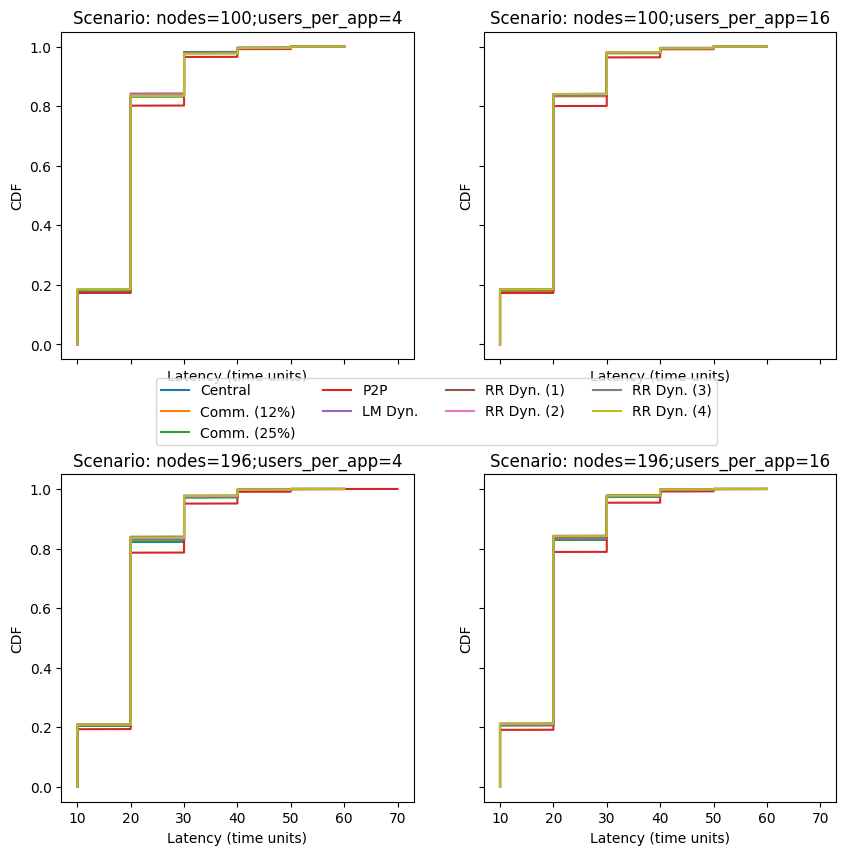

In [18]:
# TODO: check how to share labels: https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, latency_df) in enumerate(latency_dfs.items()):
    latency_df["Delays"] = latency_df["Delays"].apply(lambda x: sorted(x))
    for index, row in latency_df.iterrows():
        ax[counter // 2][counter % 2].plot(row["Delays"], np.linspace(0, 1, len(row["Delays"])))
        customize_chart(ax[counter // 2][counter % 2], xlabel="Latency (time units)", ylabel="CDF", title=f"Scenario: {key}")

fig.legend(algorithm_labels, loc='center', ncols=4, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.35)

plt.savefig(f"{base_dir}/latency.pdf", bbox_inches='tight')

### Provisioning Time

In [19]:
provisioning_time_dfs = {
    "nodes=100;users_per_app=4": get_provisioning_time_data(last_step, 100, 4),
    "nodes=100;users_per_app=16": get_provisioning_time_data(last_step, 100, 16),
    "nodes=196;users_per_app=4": get_provisioning_time_data(last_step, 196, 4),
    "nodes=196;users_per_app=16": get_provisioning_time_data(last_step, 196, 16),
}

#### Comparative Table

In [20]:
provisioning_time_tables = {}

for key, provisioning_time_df in provisioning_time_dfs.items():
    provisioning_time_table = calculate_relative_difference(provisioning_time_df, "Mean")
    provisioning_time_table = provisioning_time_table[["Algorithm", "Mean", "Central", "Comm (12%)", "Comm (25%)", "P2P"]]
    provisioning_time_table.to_csv(f"{base_dir}/provisioning_time;{key}.csv", index=False, sep=";", decimal=",")
    provisioning_time_tables[key] = provisioning_time_table

provisioning_time_tables_grid = [
    [
        provisioning_time_tables["nodes=100;users_per_app=4"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=100;users_per_app=4} \\\\\n\\toprule"),
        provisioning_time_tables["nodes=100;users_per_app=16"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=100;users_per_app=16} \\\\\n\\toprule"),
    ],
    [
        provisioning_time_tables["nodes=196;users_per_app=4"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=196;users_per_app=4} \\\\\n\\toprule"),
        provisioning_time_tables["nodes=196;users_per_app=16"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=196;users_per_app=16} \\\\\n\\toprule"),
    ]
]

provisioning_time_tables_grid_latex_string = create_grid_of_latex_tables(provisioning_time_tables_grid, "Provisioning time comparison between algorithms in multiple scenarios.", "tab:provisioning-time", "footnotesize", "portrait")

with open(f"{base_dir}/provisioning_time_tables.tex", "w") as f:
    f.write(provisioning_time_tables_grid_latex_string)

#### CDF Chart

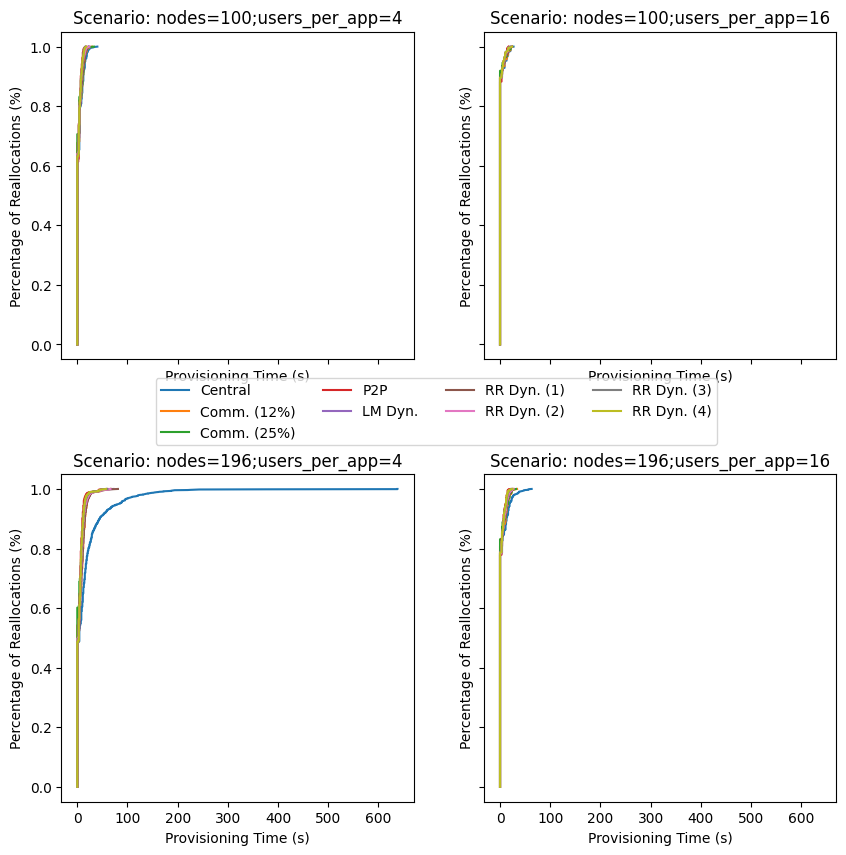

In [21]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, provisioning_time_df) in enumerate(provisioning_time_dfs.items()):
    provisioning_time_df["Prov. Time Values"] = provisioning_time_df["Prov. Time Values"].apply(lambda x: sorted(x))
    for index, row in provisioning_time_df.iterrows():
        ax[counter // 2][counter % 2].plot(row["Prov. Time Values"], np.linspace(0, 1, len(row["Prov. Time Values"])))
        customize_chart(ax[counter // 2][counter % 2], xlabel="Provisioning Time (s)", ylabel="Percentage of Reallocations (%)", title=f"Scenario: {key}")

fig.legend(algorithm_labels, loc='center', ncols=4, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.35)

plt.savefig(f"{base_dir}/provisioning_time.pdf", bbox_inches='tight')

### Service Reallocations

In [22]:
reallocations_dfs = {
    "nodes=100;users_per_app=4": get_reallocations_data(last_step, 100, 4),
    "nodes=100;users_per_app=16": get_reallocations_data(last_step, 100, 16),
    "nodes=196;users_per_app=4": get_reallocations_data(last_step, 196, 4),
    "nodes=196;users_per_app=16": get_reallocations_data(last_step, 196, 16),
}

In [23]:
for key, reallocations_df in reallocations_dfs.items():
    reallocations_df = reallocations_df[["Algorithm", "Only Using Cache (%)", "Partially Using Cache (%)", "Not Using Cache (%)"]]
    print(f"Reallocation data for scenario {key}")
    print(reallocations_df.to_string())

Reallocation data for scenario nodes=100;users_per_app=4
     Algorithm  Only Using Cache (%)  Partially Using Cache (%)  Not Using Cache (%)
0      Central              0.651308                   0.220423             0.128269
1        Comm.              0.680307                   0.191816             0.127877
2        Comm.              0.707692                   0.182051             0.110256
3          P2P              0.614540                   0.237311             0.148148
4      LM Dyn.              0.640000                   0.221935             0.138065
5  RR Dyn. (1)              0.641944                   0.221228             0.136829
6  RR Dyn. (2)              0.642132                   0.222081             0.135787
7  RR Dyn. (3)              0.633987                   0.228758             0.137255
8  RR Dyn. (4)              0.632732                   0.231959             0.135309
Reallocation data for scenario nodes=100;users_per_app=16
     Algorithm  Only Using Cache (%

#### Stacked Bar Chart

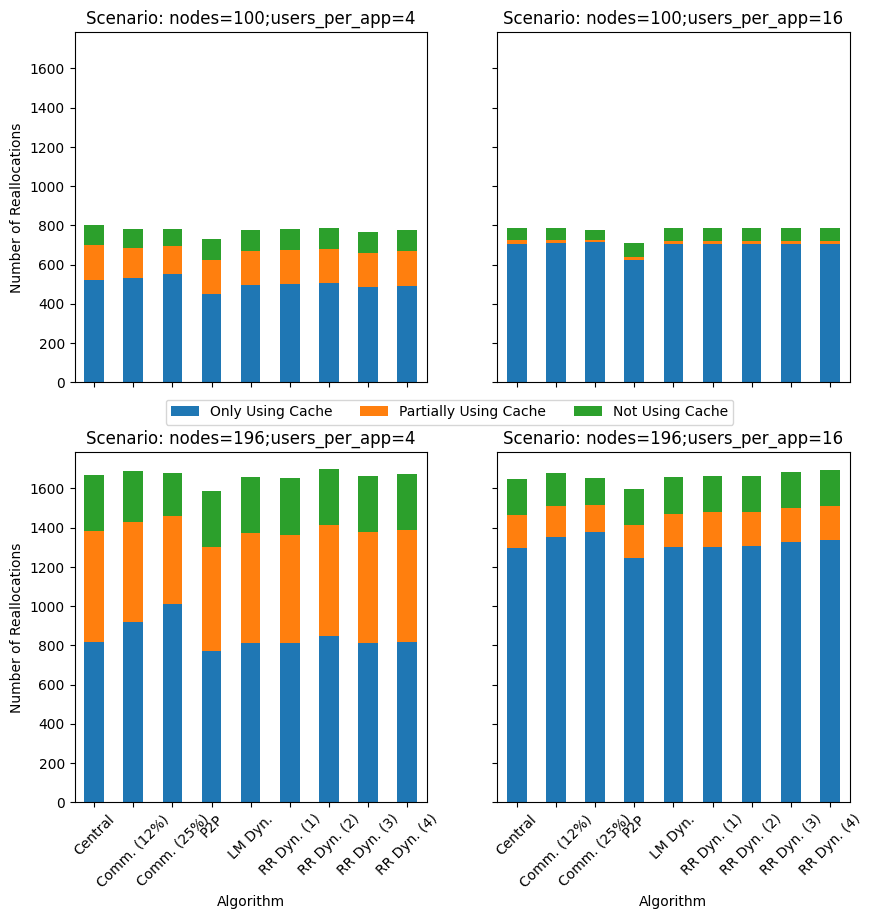

In [24]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, reallocations_df) in enumerate(reallocations_dfs.items()):
    reallocations_df = reallocations_df[["Algorithm", "Only Using Cache", "Partially Using Cache", "Not Using Cache"]]
    reallocations_df.plot.bar(x="Algorithm", stacked=True, ax=ax[counter // 2][counter % 2], rot=45, legend=False)
    customize_chart(ax[counter // 2][counter % 2], xticklabels={"labels": algorithm_labels}, xlabel="Algorithm", ylabel="Number of Reallocations", title=f"Scenario: {key}")

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncols=3, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.2)

plt.savefig(f"{base_dir}/reallocations.pdf", bbox_inches='tight')

# TODO: add labels to the bars (%)

### Registry Usage

In [25]:
registry_usage_dfs = {
    "nodes=100;users_per_app=4": get_registry_usage_data(100, 4),
    "nodes=100;users_per_app=16": get_registry_usage_data(100, 16),
    "nodes=196;users_per_app=4": get_registry_usage_data(196, 4),
    "nodes=196;users_per_app=16": get_registry_usage_data(196, 16),
}

#### Boxplot Chart (All Registries)

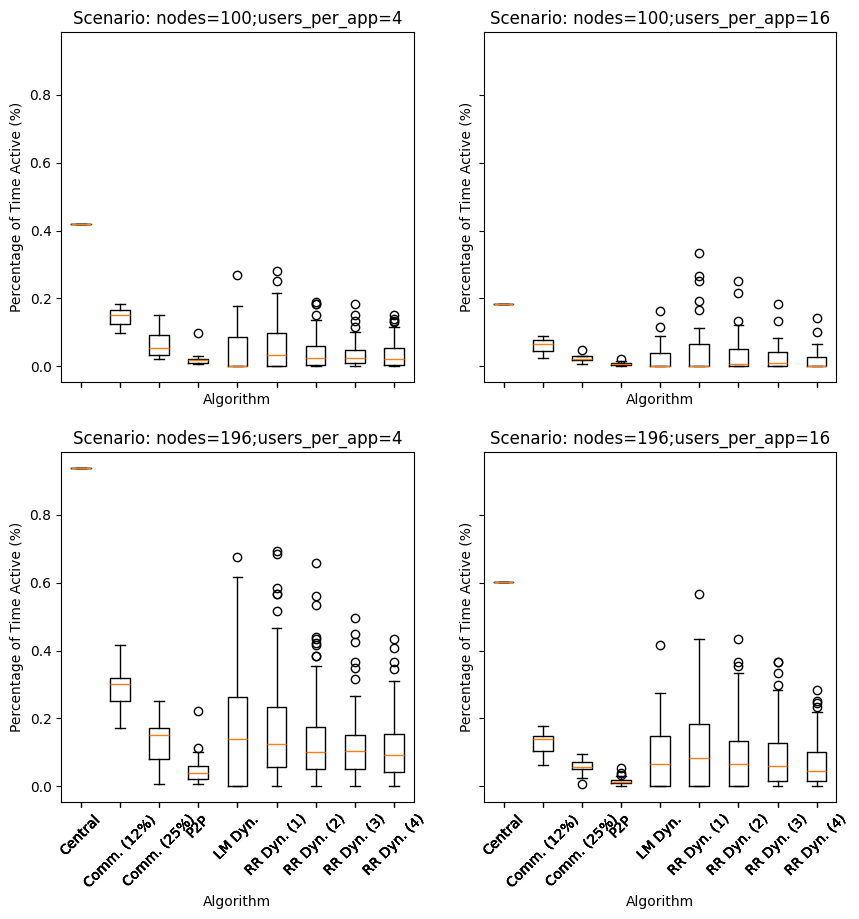

In [26]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, registry_usage_df) in enumerate(registry_usage_dfs.items()):
    registry_usage_df = registry_usage_df[["Algorithm", "Values"]]
    ax[counter // 2][counter % 2].boxplot(registry_usage_df["Values"], labels=algorithm_labels)
    customize_chart(ax[counter // 2][counter % 2], xlabel="Algorithm", ylabel="Percentage of Time Active (%)", title=f"Scenario: {key}")
    for tick in ax[counter // 2][counter % 2].get_xticklabels():
        tick.set_rotation(45)

plt.savefig(f"{base_dir}/registry_usage.pdf", bbox_inches='tight')

# TODO: customize outliers

#### Boxplot Chart (Only Registries with Some Activity)

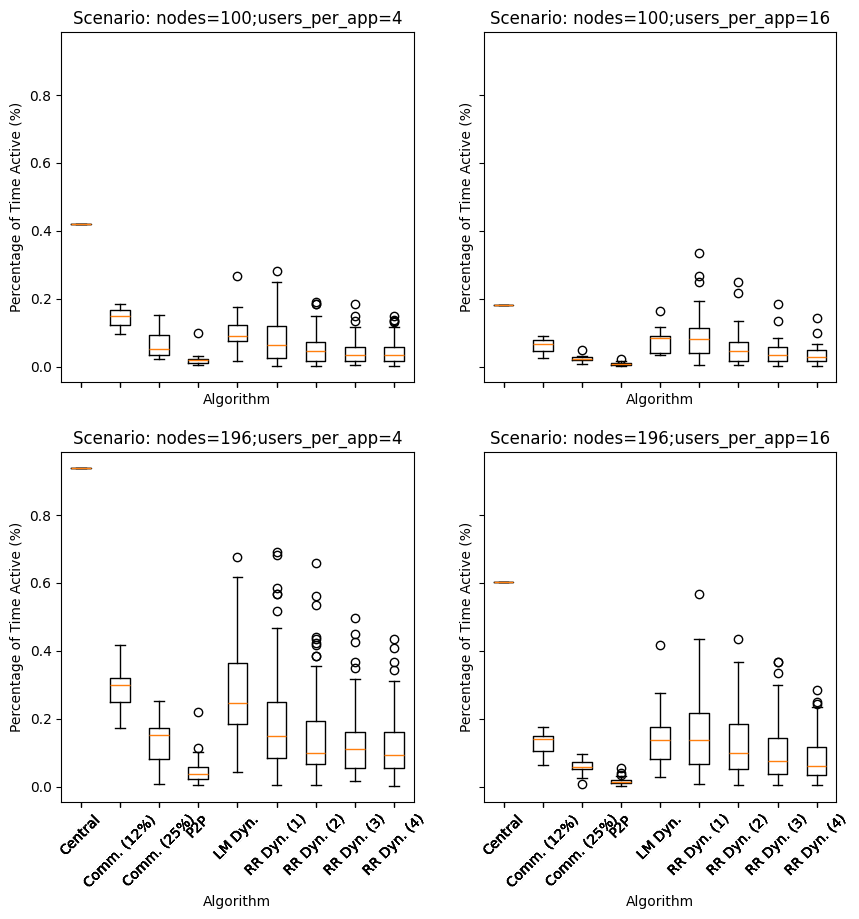

In [27]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, registry_usage_df) in enumerate(registry_usage_dfs.items()):
    registry_usage_df = registry_usage_df[["Algorithm", "Values (w/o 0%)"]]
    ax[counter // 2][counter % 2].boxplot(registry_usage_df["Values (w/o 0%)"], labels=algorithm_labels)
    customize_chart(ax[counter // 2][counter % 2], xlabel="Algorithm", ylabel="Percentage of Time Active (%)", title=f"Scenario: {key}")
    for tick in ax[counter // 2][counter % 2].get_xticklabels():
        tick.set_rotation(45)

plt.savefig(f"{base_dir}/registry_usage_without_0.pdf", bbox_inches='tight')

# TODO: customize outliers

### Number of Registries per Time Step

In [28]:
number_of_registries_dfs = {
    "nodes=100;users_per_app=4": get_number_of_registries_data(100, 4),
    "nodes=100;users_per_app=16": get_number_of_registries_data(100, 16),
    "nodes=196;users_per_app=4": get_number_of_registries_data(196, 4),
    "nodes=196;users_per_app=16": get_number_of_registries_data(196, 16),
}

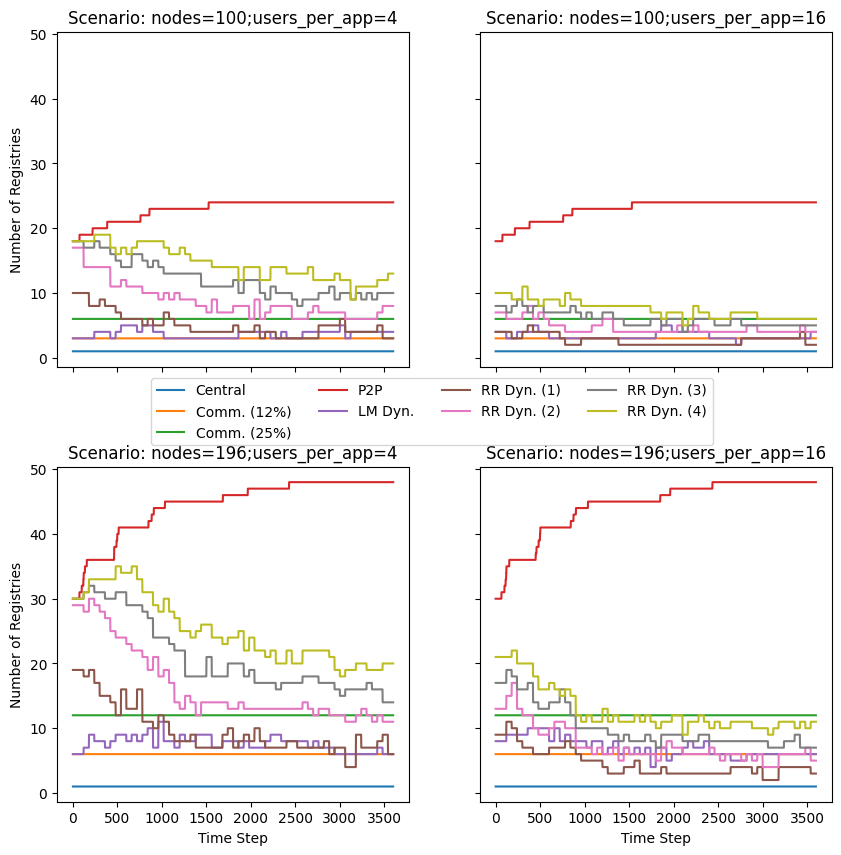

In [29]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, number_of_registries_df) in enumerate(number_of_registries_dfs.items()):
    number_of_registries_df.plot(ax=ax[counter // 2][counter % 2], legend=False)
    customize_chart(ax[counter // 2][counter % 2], xlabel="Time Step", ylabel="Number of Registries", title=f"Scenario: {key}")

handles, _ = plt.gca().get_legend_handles_labels()
fig.legend(handles, algorithm_labels, loc='center', ncols=4, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{base_dir}/number_of_registries.pdf", bbox_inches='tight')

### Server Utilization per Time Step

In [30]:
server_utilization_dfs = {
    "nodes=100;users_per_app=4": get_server_utilization_data(100, 4),
    "nodes=100;users_per_app=16": get_server_utilization_data(100, 16),
    "nodes=196;users_per_app=4": get_server_utilization_data(196, 4),
    "nodes=196;users_per_app=16": get_server_utilization_data(196, 16),
}

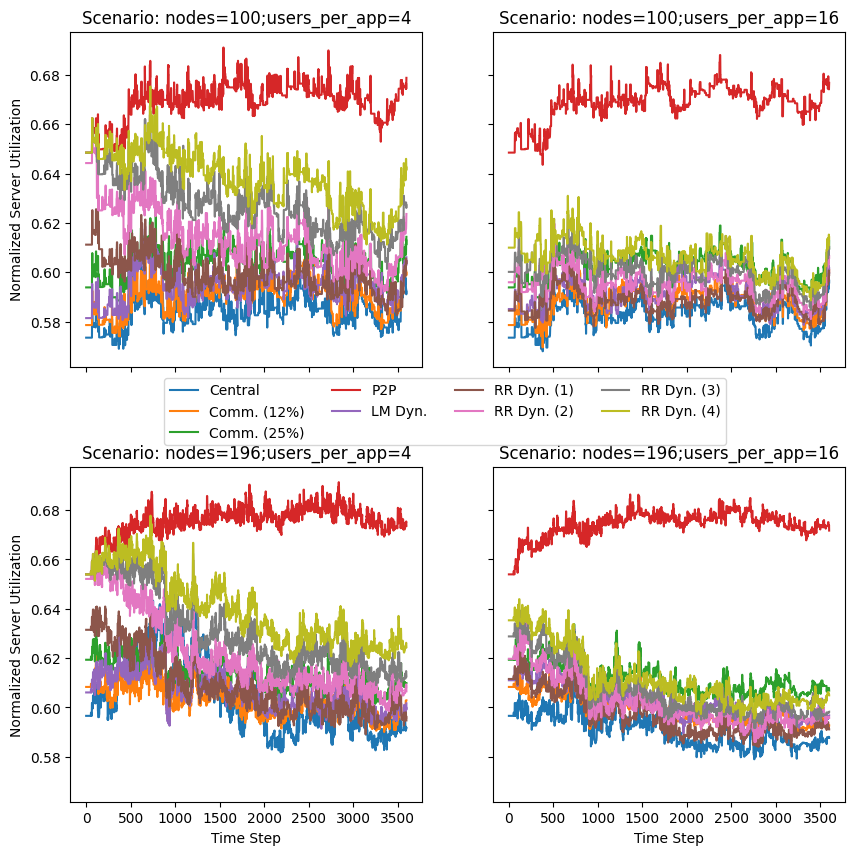

In [31]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, server_utilization_df) in enumerate(server_utilization_dfs.items()):
    server_utilization_df.plot(ax=ax[counter // 2][counter % 2], legend=False)
    customize_chart(ax[counter // 2][counter % 2], xlabel="Time Step", ylabel="Normalized Server Utilization", title=f"Scenario: {key}")

handles, _ = plt.gca().get_legend_handles_labels()
fig.legend(handles, algorithm_labels, loc='center', ncols=4, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{base_dir}/server_utilization.pdf", bbox_inches='tight')

### Image replication

In [36]:
number_of_nodes = 100
users_per_app = 4

local_logs = [
    #("central", f"central;nodes={number_of_nodes};occupation={infrastructure_occupation}"),
    #("community", f"community14p;nodes={number_of_nodes};occupation={infrastructure_occupation}"),
    #("community", f"community28p;nodes={number_of_nodes};occupation={infrastructure_occupation}"),
    ("p2p", f"p2p;nodes={number_of_nodes};users_per_app={users_per_app}"),
    ("dynamic", f"p2p;nodes={number_of_nodes};users_per_app={users_per_app}"),
    ("resource_aware_dynamic", f"p2p;nodes={number_of_nodes};users_per_app={users_per_app}", 1),
    ("resource_aware_dynamic", f"p2p;nodes={number_of_nodes};users_per_app={users_per_app}", 2),
    ("resource_aware_dynamic", f"p2p;nodes={number_of_nodes};users_per_app={users_per_app}", 3),
    ("resource_aware_dynamic", f"p2p;nodes={number_of_nodes};users_per_app={users_per_app}", 4),
]

image_replication_data = [
    get_image_replication_data(log) for log in local_logs
]

headers = [
    image_replication_data[index].columns.values.tolist() for index in range(len(image_replication_data))
]

max_length = max([len(header) for header in headers])
header_with_max_length = headers[[len(header) for header in headers].index(max_length)]

global_colormap = mpl.colormaps["tab20c"].resampled(max_length)

In [37]:
# TODO: fix when it does not start with zero
headers

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4, 5],
 [0, 1, 2, 3, 4, 5, 6, 7],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]

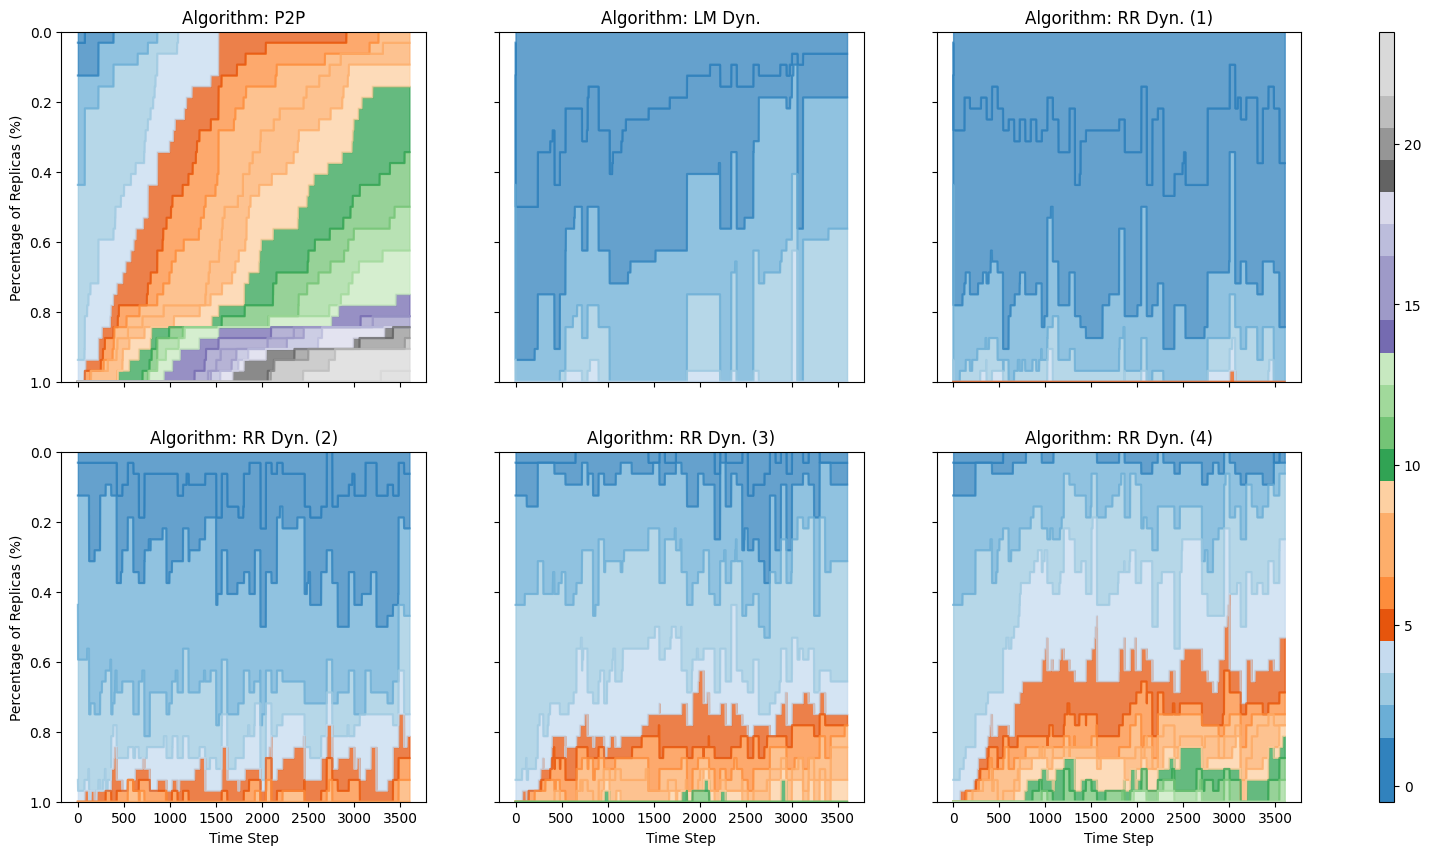

In [38]:
# plot stacked area chart for each algorithm in multiple figures using a single legend
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)

for counter, image_replication_df in enumerate(image_replication_data):
    local_color_map = mpl.colors.ListedColormap(global_colormap.colors[:len(image_replication_df.columns)])
    image_replication_df.plot.area(ax=ax[counter // 3][counter % 3], legend=False, alpha=0.75, cmap=local_color_map)
    ax[counter // 3][counter % 3].set_ylim([0, 1])
    ax[counter // 3][counter % 3].invert_yaxis()
    customize_chart(ax[counter // 3][counter % 3], xlabel="Time Step", ylabel="Percentage of Replicas (%)", title=f"Algorithm: {algorithm_labels[counter+3]}")

# create a single colorbar for all figures
fig.colorbar(mpl.cm.ScalarMappable(cmap=global_colormap), ax=ax, orientation="vertical", aspect=50, values=header_with_max_length)

plt.savefig(f"{base_dir}/image_replication.pdf", bbox_inches='tight')

### Disk Utilization per Time Step

In [39]:
disk_utilization_dfs = {
    "nodes=100;users_per_app=4": get_disk_utilization_data(100, 4),
    "nodes=100;users_per_app=16": get_disk_utilization_data(100, 16),
    "nodes=196;users_per_app=4": get_disk_utilization_data(196, 4),
    "nodes=196;users_per_app=16": get_disk_utilization_data(196, 16),
}

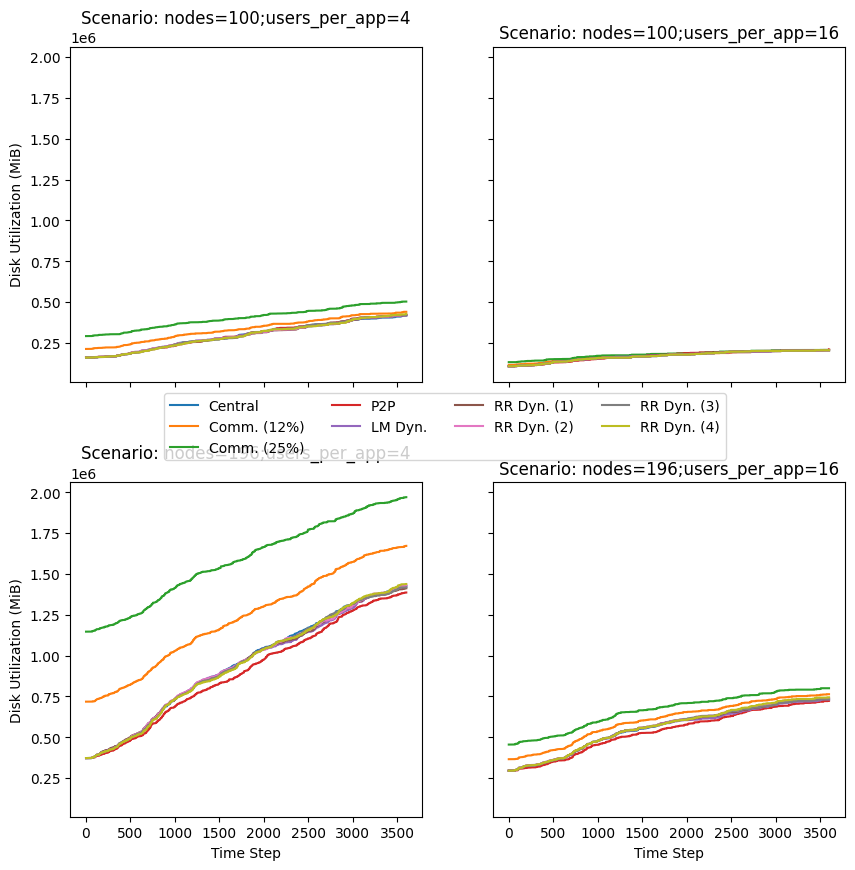

In [40]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, disk_utilization_df) in enumerate(disk_utilization_dfs.items()):
    disk_utilization_df.plot(ax=ax[counter // 2][counter % 2], legend=False)
    customize_chart(ax[counter // 2][counter % 2], xlabel="Time Step", ylabel="Disk Utilization (MiB)", title=f"Scenario: {key}")

handles, _ = plt.gca().get_legend_handles_labels()
fig.legend(handles, algorithm_labels, loc='center', ncols=4, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{base_dir}/disk_utilization.pdf", bbox_inches='tight')

### Total Disk Utilization

In [41]:
total_disk_utilization_dfs = {
    "nodes=100;users_per_app=4": get_total_disk_utilization_data(100, 4),
    "nodes=100;users_per_app=16": get_total_disk_utilization_data(100, 16),
    "nodes=196;users_per_app=4": get_total_disk_utilization_data(196, 4),
    "nodes=196;users_per_app=16": get_total_disk_utilization_data(196, 16),
}

In [42]:
total_disk_utilization_tables = {}

for key, total_disk_utilization_df in total_disk_utilization_dfs.items():
    total_disk_utilization_df_table = total_disk_utilization_df[["Algorithm", "Total Disk Occupation"]]
    total_disk_utilization_df_table.to_csv(f"{base_dir}/total_disk;{key}.csv", index=False, sep=";", decimal=",")
    total_disk_utilization_tables[key] = total_disk_utilization_df_table

total_disk_tables_grid = [
    [
        total_disk_utilization_tables["nodes=100;users_per_app=4"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=100;users_per_app=4} \\\\\n\\toprule"),
        total_disk_utilization_tables["nodes=100;users_per_app=16"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=100;users_per_app=16} \\\\\n\\toprule"),
    ],
    [
        total_disk_utilization_tables["nodes=196;users_per_app=4"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=196;users_per_app=4} \\\\\n\\toprule"),
        total_disk_utilization_tables["nodes=196;users_per_app=16"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=196;users_per_app=16} \\\\\n\\toprule"),
    ]
]

total_disk_tables_grid_latex_string = create_grid_of_latex_tables(total_disk_tables_grid, "Total disk utilization comparison between algorithms in multiple scenarios.", "tab:total-disk", "footnotesize", "portrait")

with open(f"{base_dir}/total_disk_tables.tex", "w") as f:
    f.write(total_disk_tables_grid_latex_string)

### Goals Table

In [45]:
# TODO: use mean values per time step
goals_tables = {}

for key, latency_df in latency_dfs.items():
    #table = latency_df[["Algorithm", "Sum"]] + provisioning_time_dfs[key][["Sum"]] + registry_usage_dfs[key][["Total"]] + total_disk_utilization_dfs[key][["Total Disk Occupation"]]
    table = pd.concat([latency_df[["Algorithm", "Sum"]], provisioning_time_dfs[key][["Sum"]], registry_usage_dfs[key][["Total"]], total_disk_utilization_dfs[key][["Total Disk Occupation"]]], axis=1)
    #table = table.rename(columns={"Sum": "Latency", "Total": "Registry Usage"})
    #table["Provisioning Time"] = table["Sum"]
    #table = table.drop(columns=["Sum"])
    table.to_csv(f"{base_dir}/goals;{key}.csv", index=False, sep=";", decimal=",")
    goals_tables[key] = table
    
goals_tables_grid = [
    [
        goals_tables["nodes=100;users_per_app=4"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=100;users_per_app=4} \\\\\n\\toprule"),
        goals_tables["nodes=100;users_per_app=16"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=100;users_per_app=16} \\\\\n\\toprule"),
    ],
    [
        goals_tables["nodes=196;users_per_app=4"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=196;users_per_app=4} \\\\\n\\toprule"),
        goals_tables["nodes=196;users_per_app=16"].to_latex(index=False, escape=False, column_format="lccccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{Scenario: nodes=196;users_per_app=16} \\\\\n\\toprule"),
    ]
]

goals_tables_grid_latex_string = create_grid_of_latex_tables(goals_tables_grid, "Goals comparison between algorithms in multiple scenarios.", "tab:goals", "footnotesize", "portrait")

with open(f"{base_dir}/goals_tables.tex", "w") as f:
    f.write(goals_tables_grid_latex_string)